This is a simple attempt to find the time constant for appropriate deconvolution using the data from June 2017. 
The base code is based on TimeConstant, but the Model is going to be shifted to try to align the Model and the Data more. (the main one being the line up of the base at zero.)
Essentially the same just with the Model shifted.

Mira

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import pickle
import seaborn as sns
import sys
import numpy as np
import scipy.optimize as op
from scipy.optimize import curve_fit

sns.set_palette("PuBuGn_d",15)
sns.set_style("whitegrid")
import emcee

In [8]:
with open('../../data/raw_data/20170615_1729_30mms_reference.pkl', 'rb') as f:
    d = pickle.load(f, encoding='latin1') 

/Users/Lab/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Lab/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


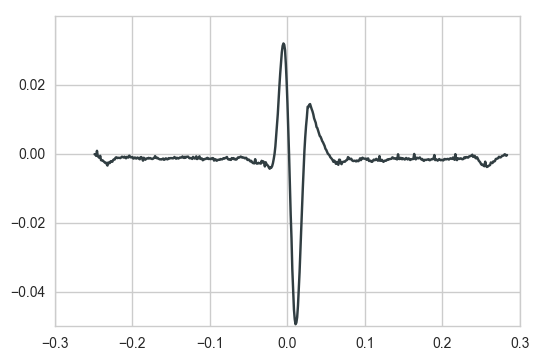

In [9]:
i = 9
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize #ending point


df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0


y = (d['sig0F']) 
D = y[startpt:endpt]
#D = np.flipud(D)

a = d['delay0F']/v
t = a[startpt:endpt]

pl.plot(t,D)

1870.5 467.5


/Users/Lab/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/Users/Lab/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


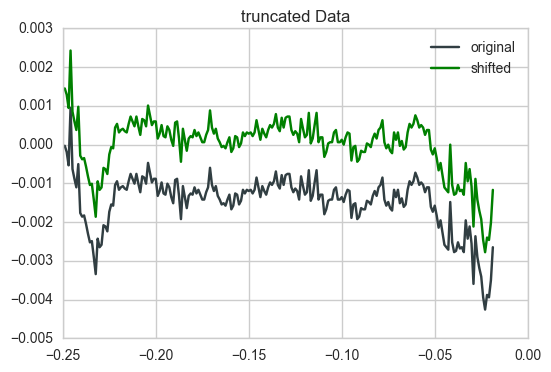

In [10]:
print (endpt, 1870/4)
#truncated to find average value of the side
D2 = y[startpt:startpt+222]
t2 = a[startpt:startpt+222]
pl.plot(t2,D2, label = 'original')
pl.title('truncated Data')
#now find the average
np.mean(D2)
pl.plot(t2, D2 + .00148, label = 'shifted', color = 'green')
pl.legend()
pl.show()

To get the bases to line up I will subtract this amount from the Model function. 

In [11]:
#model function convoluted with RC circuit and AC coupling function
def psi1(znot,q,p,T):
    Ns = Nsize
    z = t
    dz = z[2]-z[1]
    f = np.linspace(0,0.5/dz, np.floor(Ns/2))
    f_full = np.linspace(0,0.5/dz, np.floor(Ns/2) +1)
    #original function
    y0=-np.cos(2*np.pi*q*(z-znot))*(np.exp(-((z-znot)**2)/(2*p**2)))/(np.sqrt(2*np.pi)*p)
    yf0=np.fft.rfft(y0)
    K_det =(1/(1+(1j*2*np.pi*f_full*T))) #kernel from detector
    K_cc =(2*np.pi*f_full*.559)/(1 + (1j*2*np.pi*.559)) #kernel from AC coupling
    K_f = np.multiply(K_det,K_cc)
    y1=np.fft.irfft(yf0*K_f*2*np.pi)
    return t,y1
#znot = 0.012, q = 8.57718120805, p = .04

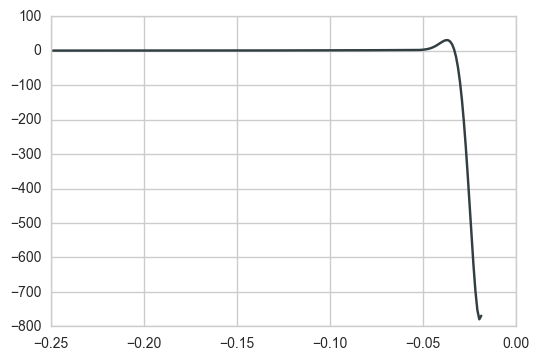

In [12]:
x,Modelf = psi1(.003,23.51,0.01335,0.0028)
D3 = Modelf[:222]
t3 = x[:222]
pl.plot(t3,D3)
pl.show()
#showing that it is located at zero

In [13]:
#likelihood function
#why is it ln?
def lnlike(params, t, D):
    znot, q, p, T, a = params 
    t,Modelf = psi1(znot,q,p, T)
    Dev = -.5*(np.dot((D-(Modelf*a-.00148)),D-(Modelf*a-.00148)))
    Sig=0.0005
    return (Dev/Sig)-np.log(1/Sig) #sigma? if sigma is large it becomes shallower

In [14]:
nll = lambda *args: -lnlike(*args) 
result = op.minimize(nll, [.003,23.51,0.01335,0.0028, .00001], args=(t,D))
znot1,q1,p1,T1,a1 = result["x"]
print (result ["x"])

[  4.08117518e-03   1.97816983e+01   1.32568793e-02   5.79709697e-05
   1.32596339e-05]


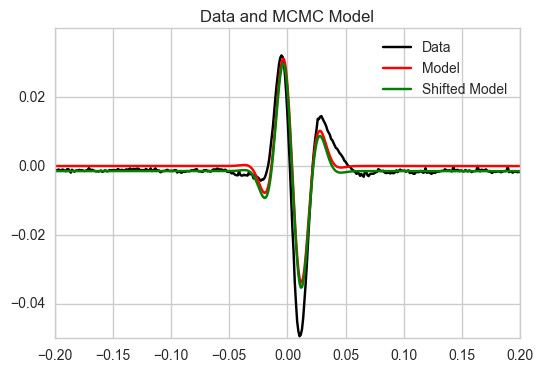

In [15]:
#VISUAL COMPARISON TO GUESS PARAMETERS BY EYE to put into optimals above.
#Also showing how model shifts.
pl.plot(t,D, label = 'Data', color = 'black')
x,Modelf = psi1(.003,23.51,0.01335,0.0028) #z,q,p,T

pl.plot(x,Modelf*.00001, label = 'Model', color = 'red')
pl.plot(x,Modelf*.00001-.00148, label = 'Shifted Model', color = 'green')
pl.xlim(-.2,.2)
pl.title('Data and MCMC Model')
pl.legend()
pl.show()

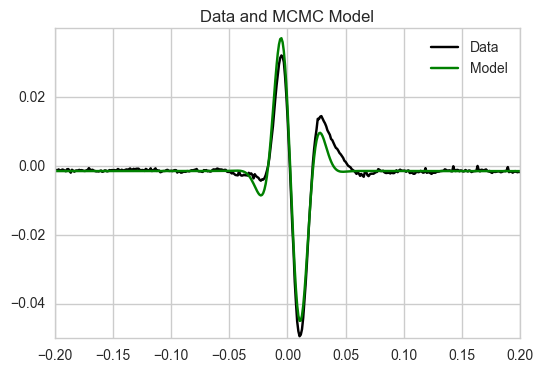

In [16]:
#using results gotten from optimization 
pl.plot(t,D, label = 'Data', color = 'black')
x,Modelf = psi1( 4.08117518e-03,   1.97816983e+01,   1.32568793e-02,   5.79709697e-05) #z,q,p,T

pl.plot(x,Modelf*1.32596339e-05-.00148, label = 'Model', color = 'green')
pl.xlim(-.2,.2)
pl.title('Data and MCMC Model')
pl.legend()
pl.show()

In [17]:
#prior function
#again, why is it ln?
def lnprior(params):
    znot, q, p, T, a = params 
    if -.08 < znot < .08 and 1.0 < q < 30.0 and .001 < p < .1 and 0.0 < T < .06 and -.005 < a < .005:
        return 0.0
    return -np.inf 
    #set znot to some delay because then tau  must move to accomodate as opposed to znot doing so. 
    #center znot at zero. (-.00001<z<.000001)
    #

In [18]:
#log probability function
def lnprob (params, t, D):
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(params, t, D)

In [19]:
ndim, nwalkers = 5,260
pos = [result["x"] + 10**(-4)*np.random.randn(ndim) for i in range(nwalkers)]

In [20]:
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob, args=(t,D))

In [21]:
sampler.run_mcmc(pos, 7000); #number of steps

(260, 7000, 5)


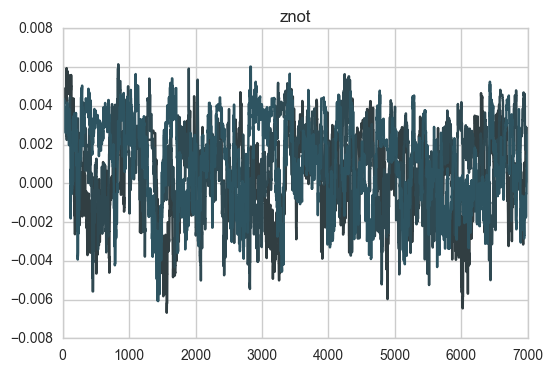

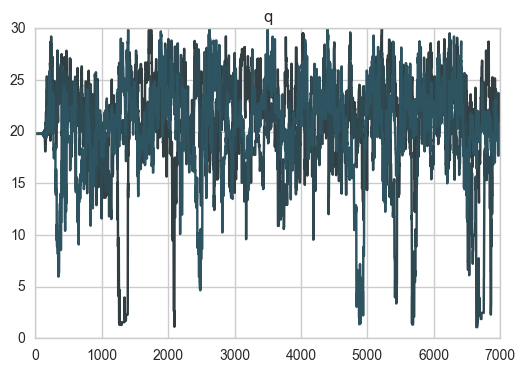

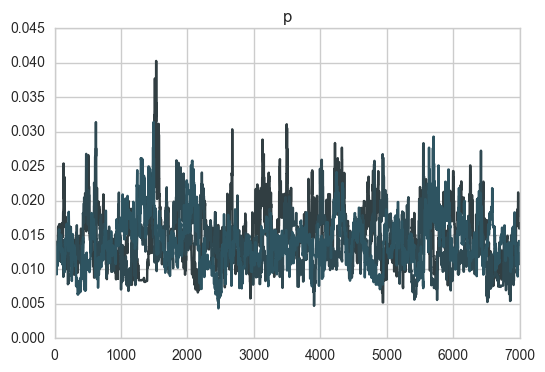

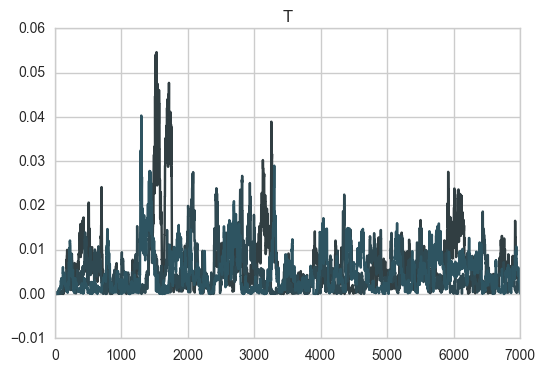

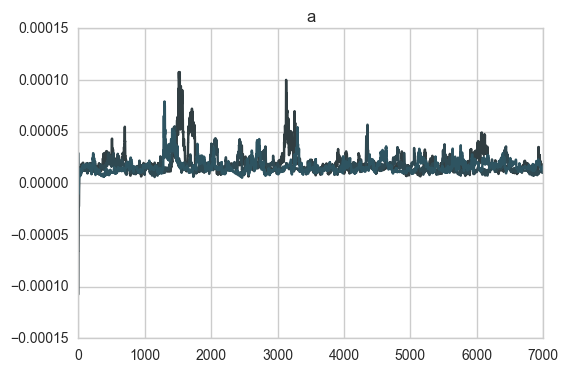

In [22]:
walks=(sampler.chain)
print(np.shape(walks))

for nn in range(0,ndim):
    pl.plot(walks[0,:,nn])
    pl.plot(walks[1,:,nn])
    pl.plot(walks[2,:,nn])
    titles = ['znot','q','p','T','a']
    pl.title(titles[nn])
    pl.show() #sigma = .001

In [23]:
samples = sampler.chain[:,2000:,:].reshape([-1, ndim])
print(np.shape(samples))

(1300000, 5)


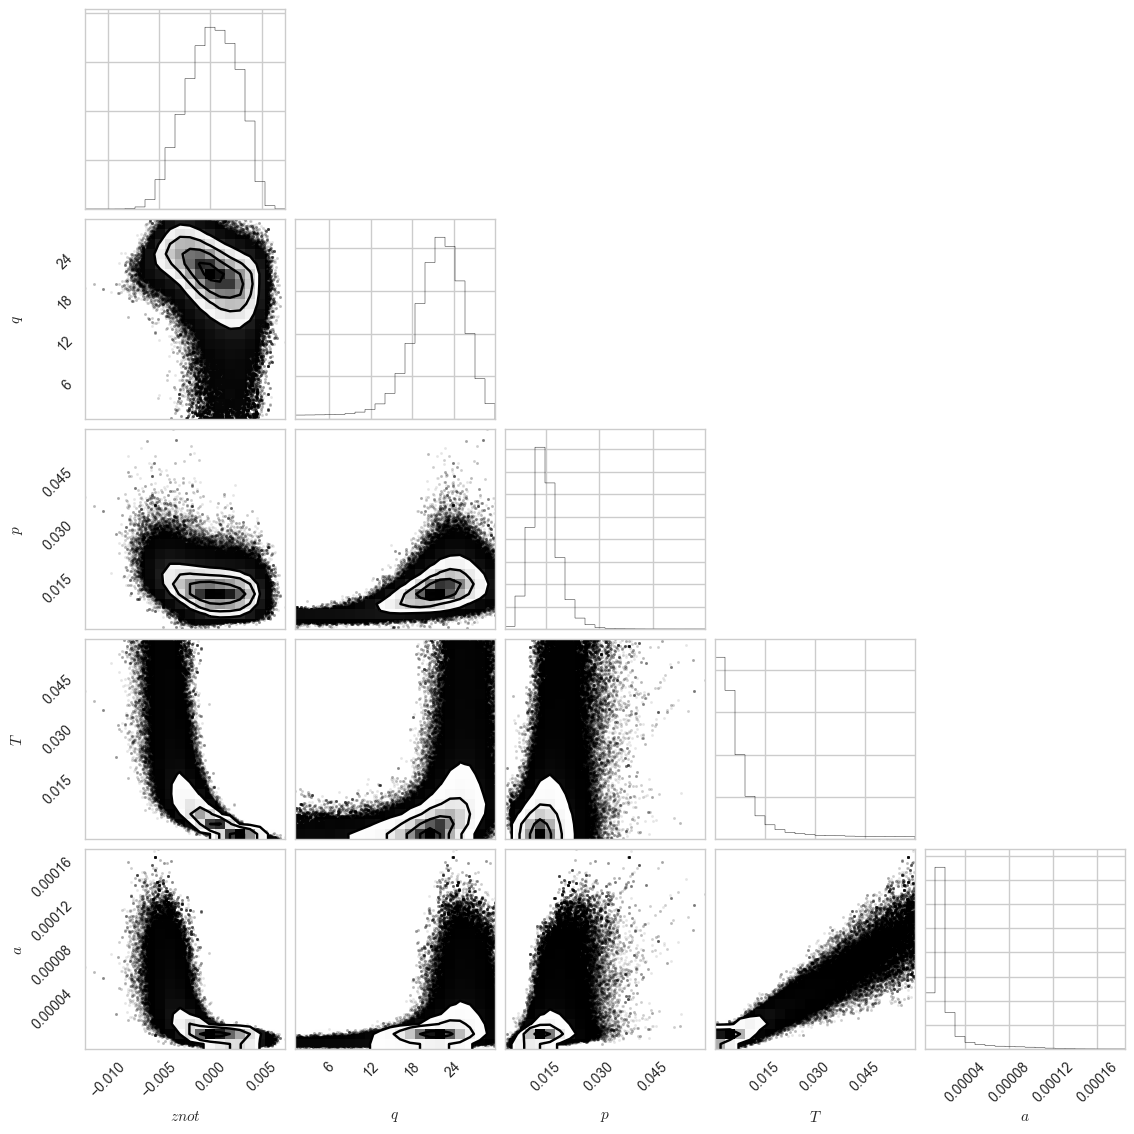

In [24]:
import corner
fig = corner.corner(samples, labels=["$znot$", "$q$", "$p$", "$T$", "$a$"]) 
#truths=[4.06765371e-03, 1.97765752e+01,   1.32557258e-02,   7.14676279e-05, 1.32627361e-05]) #znot: -.02
fig.savefig("MCMCattempt2.png")

Histograms shown below.

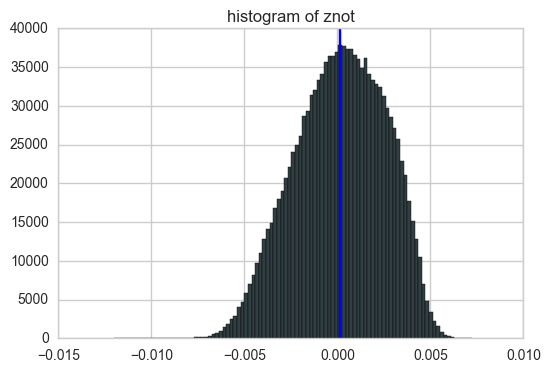

In [32]:
#histogram of znot
pl.hist(samples[:,0], 100,)
pl.title('histogram of znot')
pl.axvline(x = np.mean(samples[:,0]))
pl.show()

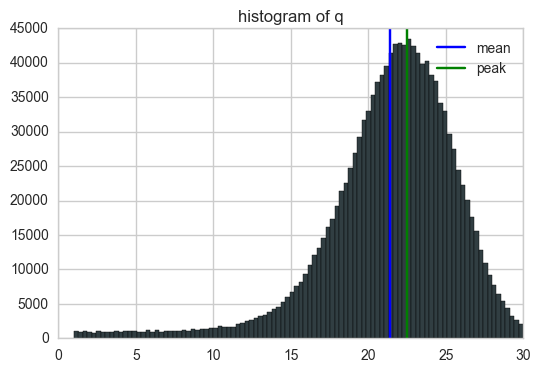

In [41]:
#histogram of q
pl.hist(samples[:,1], 100,)
pl.title('histogram of q')
pl.axvline(x = np.mean(samples[:,1]), label = 'mean')
pl.axvline(x = 22.5, label = 'peak', color = 'green')
pl.legend()
pl.show()

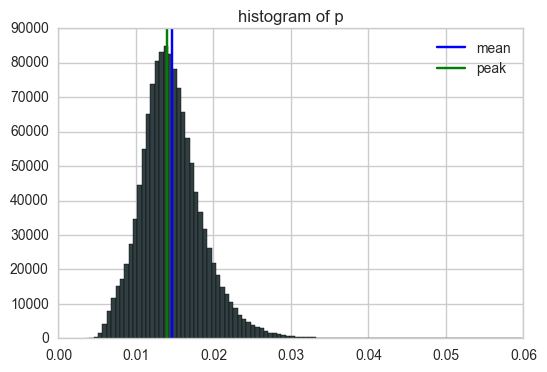

In [45]:
#histogram of p
pl.hist(samples[:,2], 100,)
pl.title('histogram of p')
pl.axvline(x = np.mean(samples[:,2]), label = 'mean')
pl.axvline(x = .01399, label = 'peak', color = 'green')
pl.legend()
pl.show()

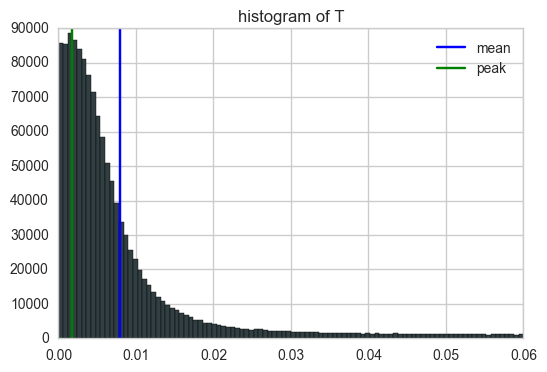

In [51]:
#histogram of T
pl.hist(samples[:,3], 100,)
pl.title('histogram of T')
pl.axvline(x = np.mean(samples[:,3]), label = 'mean')
pl.axvline(x = .00173, label = 'peak', color = 'green')
pl.legend()
pl.show()

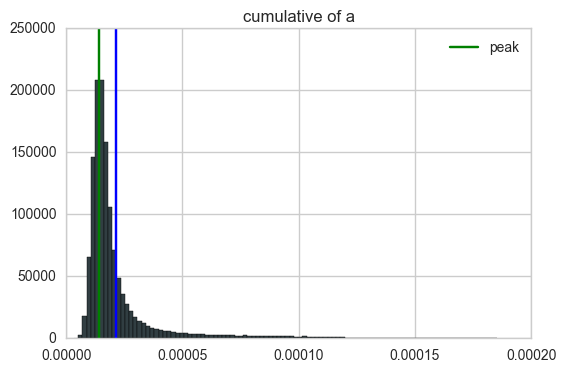

In [55]:
#histogram of a
pl.hist(samples[:,4], 100,)
pl.title('cumulative of a')
pl.axvline(x = np.mean(samples[:,4]))
pl.axvline(x = .000014, label = 'peak', color = 'green')
pl.legend()
pl.show()

In [30]:
print ('z_not: ', np.mean(samples[:,0]))
print ('q: ', np.mean(samples[:,1]))
print ('p: ', np.mean(samples[:,2]))
print ('T: ', np.mean(samples[:,3]))
print ('A: ', np.mean(samples[:,4]))

z_not:  0.000157881588507
q:  21.3790525768
p:  0.0146442984523
T:  0.00795999628391
A:  2.16095251255e-05


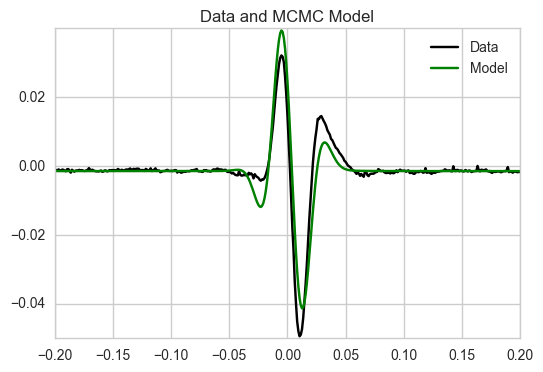

In [31]:
#plugging in the MEANS gotten from the MCMC 
pl.plot(t,D, label = 'Data', color = 'black')
x,Modelf = psi1( 0.000157881588507,   21.3790525768,   0.0146442984523,   .00795999628391) #z,q,p,T

pl.plot(x,Modelf*2.16095251255e-05-.00148, label = 'Model', color = 'green')
pl.xlim(-.2,.2)
pl.title('Data and MCMC Model')
pl.legend()
pl.show()

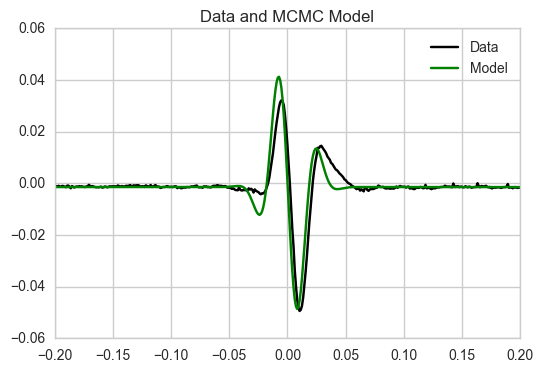

In [56]:
#plugging in the PEAKS gotten from the MCMC 
pl.plot(t,D, label = 'Data', color = 'black')
x,Modelf = psi1( 0.000157881588507,   22.5,   0.01399,   .00173) #z,q,p,T

pl.plot(x,Modelf*.000014-.00148, label = 'Model', color = 'green')
pl.xlim(-.2,.2)
pl.title('Data and MCMC Model')
pl.legend()
pl.show()